<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Austin precincts model -- Part 2

Since the precincts model got so overwhelming, I'm gonna simplify everything that has been done here and then start from phase 2 (joining/model itself).

LOTS of metadata will go on the previous kernel, so be sure to review it once all is done and when moving to automation or generailzation to more departments.

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
# imports

from collections import defaultdict, OrderedDict

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from shapely.geometry import Point
from shapely.ops import cascaded_union

# config

pd.options.display.max_colwidth = 500

%matplotlib inline

In [3]:
# projections


# World Geodetic System: 1984 (standard)
epsg4326 = {'init': 'epsg:4326'}

# USA_Contiguous_Albers_Equal_Area_Conic (for areas)
esri102003 = '+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs '

# NAD 1983 StatePlane Texas Central FIPS 4203 Feet (for imports)
esri102739 = '+proj=lcc +lat_1=30.11666666666667 +lat_2=31.88333333333333 +lat_0=29.66666666666667 +lon_0=-100.3333333333333 +x_0=700000 +y_0=3000000 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 no_defs'

# Prepare data

## Load shapefiles

In [4]:
path = '../../data/census/2015/shapefiles/texas'
census = gpd.read_file(path)
census = census.set_index('GEOID')
census.index = census.index.astype('int64')
census = census.to_crs(epsg4326)
census.head().drop('geometry', axis=1)

,STATEFP,COUNTYFP,TRACTCE,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON
GEOID,,,,,,,,,,,
48201542301,48,201,542301,5423.01,Census Tract 5423.01,G5020,S,5956745,15456,+29.8204990,-095.7316493
48157673800,48,157,673800,6738,Census Tract 6738,G5020,S,14100074,1008190,+29.5874575,-095.7125243
48157674000,48,157,674000,6740,Census Tract 6740,G5020,S,4826110,65291,+29.5869509,-095.6224534
48157674100,48,157,674100,6741,Census Tract 6741,G5020,S,4170610,0,+29.5791692,-095.5995891
48201552601,48,201,552601,5526.01,Census Tract 5526.01,G5020,S,2911911,4263,+29.9629845,-095.5679180


In [5]:
path = '../../data/departments/37-00027/external/shapefiles'
districts = gpd.read_file(path)
districts.crs = esri102739
districts = districts.to_crs(epsg4326)
districts.head().drop('geometry', axis=1)

,NAME,SORTORDER,BATID,JURIID,COLOR,CODE,EXTERNALKE,BATTALIONC,DISTRICT,SECTOR,INPUT_DATE,MODIFIED_D,INPUT_BY,MODIFIED_B,BUREAU,PATROL_ARE,AREACOMMAN,SHAPE_AREA,SHAPE_LEN
0,CHARLIE 4,1.0,400.0,11.0,16744576.0,1282,1282,CHAR,CHARLIE 4,CHARLIE,2014-12-22,None,bmartinlimuel,None,CENTRAL,CENTRALEAST,512-974-5900,6.657440e+08,387953.791071
1,GEORGE 1,1.0,194.0,15.0,16744576.0,1298,1298,G1,GEORGE 1,GEORGE,2014-12-22,None,bmartinlimuel,None,NORTH,DTAC,512-974-5203,2.790690e+07,23590.887752
2,GEORGE 2,1.0,194.0,15.0,16776960.0,1297,1297,G1,GEORGE 2,GEORGE,2014-12-22,None,bmartinlimuel,None,NORTH,DTAC,512-974-5203,9.667245e+06,19773.819675
3,IDA 1,1.0,215.0,60.0,16744576.0,1307,1307,I1,IDA 1,IDA,2014-12-22,None,bmartinlimuel,None,CENTRAL,NORTHCENTRAL,512-974-5203,1.054603e+08,48972.544807
4,IDA 2,1.0,215.0,60.0,16711680.0,1304,1304,I1,IDA 2,IDA,2014-12-22,None,bmartinlimuel,None,CENTRAL,NORTHCENTRAL,512-974-5203,6.245594e+07,38742.443899


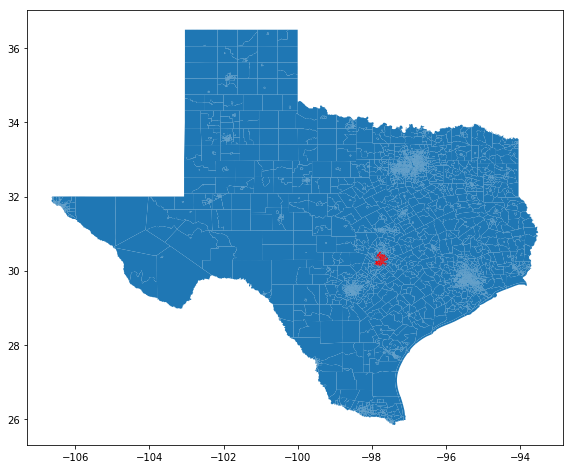

In [6]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_aspect('equal')

census.plot(ax=ax)
districts.plot(ax=ax, color='red')

## Scope census data 

In [7]:
census = census[census.geometry.intersects(districts.unary_union)]
census.head().drop('geometry', axis=1)

,STATEFP,COUNTYFP,TRACTCE,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON
GEOID,,,,,,,,,,,
48209010908,48,209,010908,109.08,Census Tract 109.08,G5020,S,39031707,874308,+30.0546634,-097.8008814
48453000402,48,453,000402,4.02,Census Tract 4.02,G5020,S,1543583,0,+30.2841390,-097.7155242
48453000500,48,453,000500,5,Census Tract 5,G5020,S,1152030,0,+30.2960656,-097.7341753
48453000601,48,453,000601,6.01,Census Tract 6.01,G5020,S,1113392,0,+30.2874117,-097.7380441
48453000801,48,453,000801,8.01,Census Tract 8.01,G5020,S,1292330,0,+30.2669542,-097.7014857


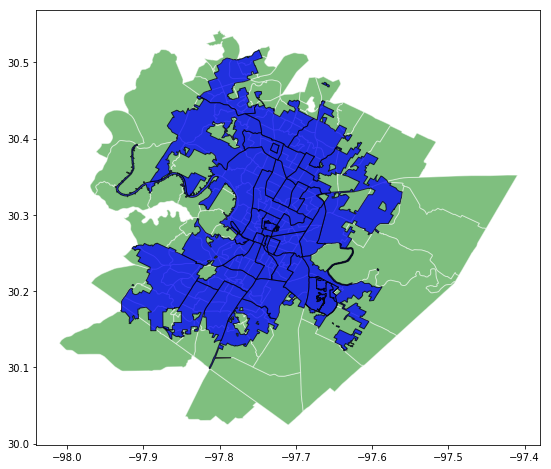

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_aspect('equal')

census.plot(ax=ax, facecolor='green', edgecolor='white', alpha=0.5)
districts.plot(ax=ax, color='blue', edgecolor='black', alpha=0.75)

## Load csv files

### Census

#### Demographics (including race)

In [9]:
path = '../../data/departments/37-00027/external/ACS/ACS_16_5YR_DP05_with_ann.csv'
demographics = pd.read_csv(path, skiprows=[1])

demographics = demographics.set_index('GEO.id2')  # int64
demographics = demographics.drop('GEO.id', axis=1)

demographics.head()

,GEO.display-label,HC01_VC03,HC02_VC03,HC03_VC03,HC04_VC03,HC01_VC04,HC02_VC04,HC03_VC04,HC04_VC04,HC01_VC05,...,HC03_VC108,HC04_VC108,HC01_VC109,HC02_VC109,HC03_VC109,HC04_VC109,HC01_VC110,HC02_VC110,HC03_VC110,HC04_VC110
GEO.id2,,,,,,,,,,,,,,,,,,,,,
48453000101,"Census Tract 1.01, Travis County, Texas",4331,282,4331,(X),1964,239,45.3,4.0,2367,...,3467,(X),1508,194,43.5,4.0,1959,166,56.5,4.0
48453000102,"Census Tract 1.02, Travis County, Texas",2572,172,2572,(X),1188,135,46.2,4.2,1384,...,1974,(X),915,107,46.4,4.7,1059,127,53.6,4.7
48453000203,"Census Tract 2.03, Travis County, Texas",1470,187,1470,(X),723,119,49.2,5.8,747,...,1248,(X),617,121,49.4,6.5,631,129,50.6,6.5
48453000204,"Census Tract 2.04, Travis County, Texas",3090,206,3090,(X),1594,187,51.6,5.0,1496,...,2481,(X),1330,181,53.6,5.5,1151,156,46.4,5.5
48453000205,"Census Tract 2.05, Travis County, Texas",4227,425,4227,(X),2405,415,56.9,5.4,1822,...,3549,(X),2077,393,58.5,5.6,1472,167,41.5,5.6


#### Poverty

In [10]:
path = '../../data/departments/37-00027/external/ACS/ACS_16_5YR_S1701_with_ann.csv'
poverty = pd.read_csv(path, skiprows=[1])

poverty = poverty.set_index('GEO.id2')
poverty = poverty.drop('GEO.id', axis=1)

poverty.head()

,GEO.display-label,HC01_EST_VC01,HC01_MOE_VC01,HC02_EST_VC01,HC02_MOE_VC01,HC03_EST_VC01,HC03_MOE_VC01,HC01_EST_VC03,HC01_MOE_VC03,HC02_EST_VC03,...,HC02_EST_VC78,HC02_MOE_VC78,HC03_EST_VC78,HC03_MOE_VC78,HC01_EST_VC79,HC01_MOE_VC79,HC02_EST_VC79,HC02_MOE_VC79,HC03_EST_VC79,HC03_MOE_VC79
GEO.id2,,,,,,,,,,,,,,,,,,,,,
48453000101,"Census Tract 1.01, Travis County, Texas",4270,276,270,104,6.3,2.4,821,133,12,...,127,66,30.6,16.4,420,99,117,65,27.9,14.2
48453000102,"Census Tract 1.02, Travis County, Texas",2570,171,81,74,3.2,2.9,571,79,23,...,4,5,2.5,3.2,255,72,43,32,16.9,11.4
48453000203,"Census Tract 2.03, Travis County, Texas",1258,174,423,142,33.6,9.1,49,40,34,...,169,73,49.9,13.2,207,96,160,90,77.3,15.7
48453000204,"Census Tract 2.04, Travis County, Texas",3042,199,589,171,19.4,5.7,426,68,37,...,341,137,55.8,14.7,244,91,168,80,68.9,17.5
48453000205,"Census Tract 2.05, Travis County, Texas",4227,425,547,325,12.9,6.7,478,160,17,...,302,221,41.4,21.6,311,163,205,141,65.9,28.9


### Department

#### Use of Force

In [11]:
def to_float(x):
    if x == '-':
        return np.nan
    return float(x)

path = '../../data/departments/37-00027/external/37-00027_UOF-P_2014-2016_prepped.csv'
uof = pd.read_csv(path, skiprows=[0])

uof['Date Occurred'] = pd.to_datetime(uof['Date Occurred'], format='%m/%d/%Y')
uof[['X-Coordinate', 'Y-Coordinate']] = uof[['X-Coordinate', 'Y-Coordinate']].applymap(to_float)
uof = uof[uof['Date Occurred'].dt.year == 2015]

uof.head()

,RIN,Primary Key,Date Occurred,Area Command,Nature of Contact,Reason Desc,Master Subject ID,Subject Sex,Race,Subject Role,...,Officer Organization Desc,Officer Yrs of Service,X-Coordinate,Y-Coordinate,City Council District,Geolocation,City,State,Latitude,Longitude
0,156701,2015541517,2015-02-24,FR,VIEWED OFFENSE,NECESSARY TO EFFECT ARREST / DETENTION,167510327: 2015541517,M,Hispanic,NaN,...,CRIMINAL INTERDICTION / K9,3,3100341.0,10030899.0,5.0,9900 BLOCK S IH 35 SB,Austin,TX,NaN,NaN
1,161046,20151510003,2015-05-31,GE,VIEWED OFFENSE,NECESSARY TO EFFECT ARREST / DETENTION,459191174: 20151510003,M,Hispanic,NaN,...,GEORGE 300 REG I PATROL,5,3115535.0,10070296.0,9.0,409 E 6TH ST,Austin,TX,NaN,NaN
2,161381,20151510003,2015-05-31,GE,VIEWED OFFENSE,"IN CUSTODY, MAINTAINING CONTROL",459191174: 20151510003,M,Hispanic,NaN,...,GEORGE 300 REG I PATROL,7,3115535.0,10070296.0,9.0,409 E 6TH ST,Austin,TX,NaN,NaN
4,162084,20151720001,2015-06-21,GE,DISPATCHED CALL,TO RESTRAIN FOR SUBJECTS SAFETY,459030448: 20151720001,M,Black,NaN,...,GEORGE 400 REG I PATROL,3,3116713.0,10067447.0,3.0,SAN MARCOS ST / SPENCE ST,Austin,TX,NaN,NaN
8,161761,20151640003,2015-06-13,CH,VIEWED OFFENSE,NECESSARY TO EFFECT ARREST / DETENTION,125633596: 20151640003,M,Black,NaN,...,METRO TAC REGION 3,6,3121725.0,10072956.0,1.0,1915 E 12TH ST,Austin,TX,NaN,NaN


#### Crimes

In [12]:
path = '../../data/departments/37-00027/raw/crime_reports.csv'
crimes = pd.read_csv(path)

crimes['Occurred Date'] = pd.to_datetime(crimes['Occurred Date'], format='%m/%d/%Y')
crimes = crimes[crimes['Occurred Date'].dt.year == 2015]
crimes = crimes[crimes['Highest Offense Description'] == 'FAMILY DISTURBANCE']

crimes.head()

,Incident Number,Highest Offense Description,Highest Offense Code,Family Violence,Occurred Date Time,Occurred Date,Occurred Time,Report Date Time,Report Date,Report Time,...,Census Tract,Clearance Status,Clearance Date,UCR Category,Category Description,X-coordinate,Y-coordinate,Latitude,Longitude,Location
9,20151020993,FAMILY DISTURBANCE,3400,N,04/12/2015 02:13:00 PM,2015-04-12,1413,04/12/2015 02:13:00 PM,04/12/2015,1413,...,21.05,N,05/06/2015,NaN,NaN,3126309.0,3126309.0,30.318529,-97.703422,"(30.3185291, -97.7034222)"
31,20152201263,FAMILY DISTURBANCE,3400,N,08/08/2015 04:50:00 PM,2015-08-08,1650,08/08/2015 05:18:00 PM,08/08/2015,1718,...,9.02,N,08/10/2015,NaN,NaN,3126941.0,3126941.0,30.254264,-97.703170,"(30.25426447, -97.70317036)"
36,20152220141,FAMILY DISTURBANCE,3400,N,08/10/2015 02:07:00 AM,2015-08-10,207,08/10/2015 02:29:00 AM,08/10/2015,229,...,23.12,N,08/10/2015,NaN,NaN,3129781.0,3129781.0,30.224783,-97.694979,"(30.22478271, -97.69497855)"
52,20153011283,FAMILY DISTURBANCE,3400,N,10/28/2015 05:09:00 PM,2015-10-28,1709,10/28/2015 05:09:00 PM,10/28/2015,1709,...,2.04,N,10/29/2015,NaN,NaN,3112691.0,3112691.0,30.309363,-97.746840,"(30.30936268, -97.74683957)"
56,2015441237,FAMILY DISTURBANCE,3400,N,02/13/2015 04:03:00 PM,2015-02-13,1603,02/13/2015 04:17:00 PM,02/13/2015,1617,...,24.23,N,02/20/2015,NaN,NaN,3091552.0,3091552.0,30.176810,-97.817303,"(30.17680953, -97.81730309)"


## Join data (census)

Join census data to the shapes.

In [13]:
df1 = census.copy()
df2 = demographics.copy()
df3 = poverty.copy()

df2.columns = ["dem_" + c for c in df2.columns]
df3.columns = ["pov_" + c for c in df3.columns]

census_joined = df1.merge(df2, left_index=True, right_index=True, how='left')
census_joined = census_joined.merge(df3, left_index=True, right_index=True, how='left')

census_joined.head().drop('geometry', axis=1)

,STATEFP,COUNTYFP,TRACTCE,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,...,pov_HC02_EST_VC78,pov_HC02_MOE_VC78,pov_HC03_EST_VC78,pov_HC03_MOE_VC78,pov_HC01_EST_VC79,pov_HC01_MOE_VC79,pov_HC02_EST_VC79,pov_HC02_MOE_VC79,pov_HC03_EST_VC79,pov_HC03_MOE_VC79
GEOID,,,,,,,,,,,,,,,,,,,,,
48209010908,48,209,010908,109.08,Census Tract 109.08,G5020,S,39031707,874308,+30.0546634,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48453000402,48,453,000402,4.02,Census Tract 4.02,G5020,S,1543583,0,+30.2841390,...,185.0,102.0,35.9,14.4,143.0,83.0,61.0,55.0,42.7,25.3
48453000500,48,453,000500,5,Census Tract 5,G5020,S,1152030,0,+30.2960656,...,895.0,232.0,64.4,10.9,521.0,229.0,457.0,224.0,87.7,10.3
48453000601,48,453,000601,6.01,Census Tract 6.01,G5020,S,1113392,0,+30.2874117,...,336.0,100.0,85.9,6.7,174.0,63.0,162.0,62.0,93.1,7.1
48453000801,48,453,000801,8.01,Census Tract 8.01,G5020,S,1292330,0,+30.2669542,...,46.0,39.0,47.9,28.3,194.0,49.0,115.0,53.0,59.3,22.0


In [14]:
census_joined.isnull().sum().value_counts()

# missing info for 18 census tracts

18    704
0      12
dtype: int64

## Aggregate data (department)

Let's aggregate the police data into the police districts where they happen.

### Use of Force

#### Add spatial column

In [15]:
points = [Point(x, y) for x, y in zip(uof['X-Coordinate'], uof['Y-Coordinate'])]
uof_spatial = gpd.GeoDataFrame(
    uof,
    geometry=points,
    crs=esri102739,
)
uof_spatial = uof_spatial.to_crs(epsg4326)

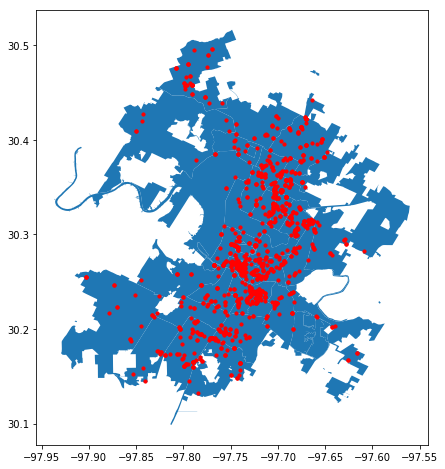

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_aspect('equal')

districts.plot(ax=ax)
uof_spatial.head(1500).plot(ax=ax, color='red', markersize=10)

#### Aggregate into police districts

In [17]:
joined = gpd.sjoin(
    districts.copy(),
    uof_spatial.copy(),
    how='left'
)
uof_per_district = joined.groupby(joined.index)['index_right'].count()

In [18]:
uof_per_district.head()

0     55
1     40
2    594
3    105
4     97
Name: index_right, dtype: int64

### Crimes

#### Add spatial column

In [19]:
cols = ['X-coordinate', 'Y-coordinate', 'Latitude', 'Longitude']
crimes[cols].corr(method='kendall')

# we MUST use lat/lon

,X-coordinate,Y-coordinate,Latitude,Longitude
X-coordinate,1.000000,1.000000,0.266564,0.976331
Y-coordinate,1.000000,1.000000,0.266564,0.976331
Latitude,0.266564,0.266564,1.000000,0.290242
Longitude,0.976331,0.976331,0.290242,1.000000


In [20]:
points = [Point(x, y) for x, y in zip(crimes['Longitude'], crimes['Latitude'])]
crimes_spatial = gpd.GeoDataFrame(
    crimes,
    geometry=points,
    crs=epsg4326,
)

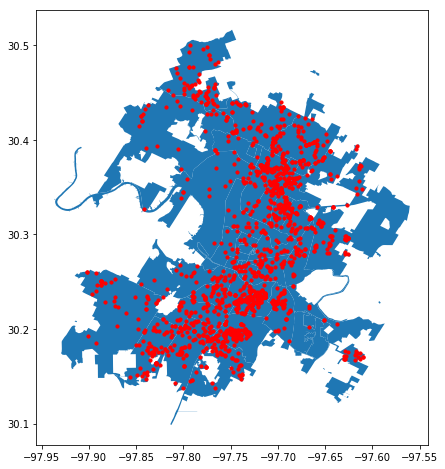

In [21]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_aspect('equal')

districts.plot(ax=ax)
crimes_spatial.head(1500).plot(ax=ax, color='red', markersize=10)

#### Aggregate into police districts

In [22]:
joined = gpd.sjoin(
    districts.copy(),
    crimes_spatial.copy(),
    how='left'
)
crimes_per_district = joined.groupby(joined.index)['index_right'].count()

In [23]:
crimes_per_district.head()

0    353
1     85
2     57
3    440
4    363
Name: index_right, dtype: int64

## Join data (department)

Let's join the previous results into the districts data.

In [24]:
districts_joined = districts.copy()
districts_joined['incident_count'] = uof_per_district
districts_joined['crime_count'] = crimes_per_district

districts_joined.head()

,NAME,SORTORDER,BATID,JURIID,COLOR,CODE,EXTERNALKE,BATTALIONC,DISTRICT,SECTOR,...,INPUT_BY,MODIFIED_B,BUREAU,PATROL_ARE,AREACOMMAN,SHAPE_AREA,SHAPE_LEN,geometry,incident_count,crime_count
0,CHARLIE 4,1.0,400.0,11.0,16744576.0,1282,1282,CHAR,CHARLIE 4,CHARLIE,...,bmartinlimuel,None,CENTRAL,CENTRALEAST,512-974-5900,6.657440e+08,387953.791071,"POLYGON ((-97.59489290692987 30.37553595219781, -97.5945671056792 30.37537897330768, -97.59441821479112 30.37530720841542, -97.59441627273767 30.37530626961498, -97.59441353252237 30.3753049527758, -97.59434498792631 30.37527201718712, -97.59433200986456 30.37526566501906, -97.59431225414093 30.37525614263433, -97.59425006304079 30.37522644550782, -97.5941909428457 30.37519787112989, -97.59417176277898 30.37518867387885, -97.59416294840828 30.37518419839592, -97.59413968555536 30.37517320867...",55,353
1,GEORGE 1,1.0,194.0,15.0,16744576.0,1298,1298,G1,GEORGE 1,GEORGE,...,bmartinlimuel,None,NORTH,DTAC,512-974-5203,2.790690e+07,23590.887752,"POLYGON ((-97.73238075061245 30.27184843482283, -97.73240149807224 30.27179305998451, -97.73285346737519 30.27057588063509, -97.73289983530437 30.27045195586341, -97.73290403973371 30.27044291003529, -97.73279494402261 30.27041233986742, -97.73272179405139 30.27039185034303, -97.73263015876765 30.27036829024802, -97.73247633998648 30.27032883606282, -97.73148636113201 30.27002822980184, -97.73085517608423 30.26978608757653, -97.73082776598672 30.26977557459625, -97.73018463793466 30.26953698...",40,85
2,GEORGE 2,1.0,194.0,15.0,16776960.0,1297,1297,G1,GEORGE 2,GEORGE,...,bmartinlimuel,None,NORTH,DTAC,512-974-5203,9.667245e+06,19773.819675,"POLYGON ((-97.73293781244578 30.27183352500005, -97.73295839470482 30.27177875695908, -97.73303327915333 30.27159490316924, -97.7331854865516 30.27117427326646, -97.73320489031545 30.271120897709, -97.73335501232179 30.27070822884334, -97.73335535122037 30.27070741061561, -97.73335562604076 30.27070661859115, -97.7334028119292 30.27059112630877, -97.73345133584269 30.27046006669076, -97.73369208756358 30.26981287151465, -97.73375350813716 30.26964763911089, -97.73378085222772 30.269565298401...",594,57
3,IDA 1,1.0,215.0,60.0,16744576.0,1307,1307,I1,IDA 1,IDA,...,bmartinlimuel,None,CENTRAL,NORTHCENTRAL,512-974-5203,1.054603e+08,48972.544807,"POLYGON ((-97.6659090431541 30.327938193942, -97.66595844038964 30.32792557452631, -97.6659943749063 30.32791631584479, -97.6660551396224 30.32790064616289, -97.66612884058171 30.32788166318054, -97.66612988452668 30.32788138923057, -97.66670275197575 30.32773435330601, -97.66670408163829 30.32773399418724, -97.66687892426255 30.32768906378495, -97.66689004044063 30.32768621453141, -97.66690113869909 30.32768336834221, -97.66733362216294 30.32757219910962, -97.66737785771171 30.3275589079913...",105,440
4,IDA 2,1.0,215.0,60.0,16711680.0,1304,1304,I1,IDA 2,IDA,...,bmartinlimuel,None,CENTRAL,NORTHCENTRAL,512-974-5203,6.245594e+07,38742.443899,"POLYGON ((-97.68322191035148 30.33734648658408, -97.68362834559186 30.33672471918451, -97.68408053953979 30.33603391077123, -97.68470362867028 30.33508104874831, -97.68616655889437 30.33286367795905, -97.68625788432898 30.3327252387909, -97.68634309336923 30.33259614149318, -97.68638240160361 30.33254422123964, -97.68667938693768 30.33215171122497, -97.68687092907859 30.33189850397422, -97.68776202811961 30.33072083436088, -97.68800287951562 30.33056244827045, -97.68824337911053 30.330404432...",97,363


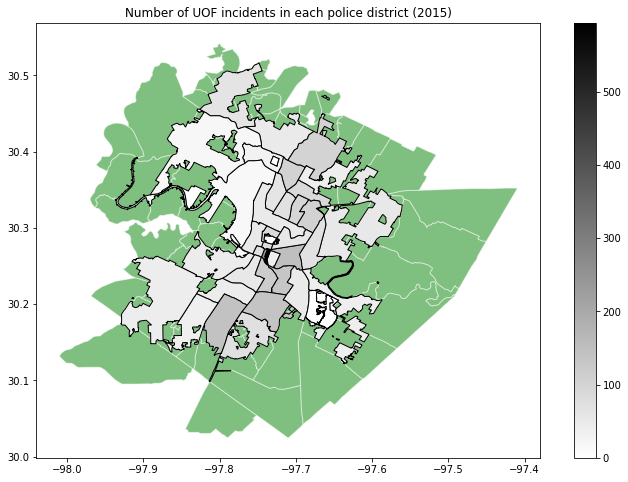

In [25]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_aspect('equal')

districts_joined.plot(ax=ax, column='incident_count', cmap='binary', edgecolor='k', legend=True)
census.plot(ax=ax, facecolor='green', edgecolor='white', alpha=0.5, zorder=-1)

ax.set_title('Number of UOF incidents in each police district (2015)');

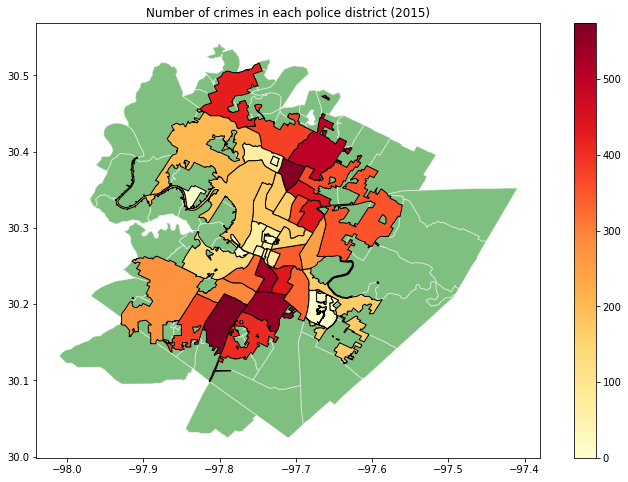

In [26]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_aspect('equal')

districts_joined.plot(ax=ax, column='crime_count', cmap='YlOrRd', edgecolor='k', legend=True)
census.plot(ax=ax, facecolor='green', edgecolor='white', alpha=0.5, zorder=-1)

ax.set_title('Number of crimes in each police district (2015)');

## Reshape census data into police districts

### Function prototype

In [27]:
df = census_joined.copy()
into = districts_joined.geometry.copy()
crs = esri102003

In [28]:
features = OrderedDict()
original_into = into.copy()

# equal area
df = df.to_crs(crs)
into = into.to_crs(crs)

feature_df = df.select_dtypes(np.number)
feature_cnt = feature_df.shape[1]

total = df.unary_union
for out_id, out_shape in into.iteritems():
    if not out_shape.within(total):
        features[out_id] = np.full(feature_cnt, np.nan)
        next
        # warning
    else:
        features[out_id] = np.zeros(feature_cnt)
        inter_df = df[df.intersects(out_shape)] 
        for idx, in_shape in inter_df.geometry.iteritems():
            pct = (in_shape & out_shape).area / in_shape.area
            if pct:  # if pct=0, we do not need to account rows without information
                features[out_id] += pct * feature_df.loc[idx]
                
features_df = gpd.GeoDataFrame(
    pd.DataFrame.from_dict(features, orient='index'),
    geometry=original_into,
)

In [29]:
districts_from_census = features_df

### Visualize

/home/andre/miniconda3/envs/cpe/lib/python3.7/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


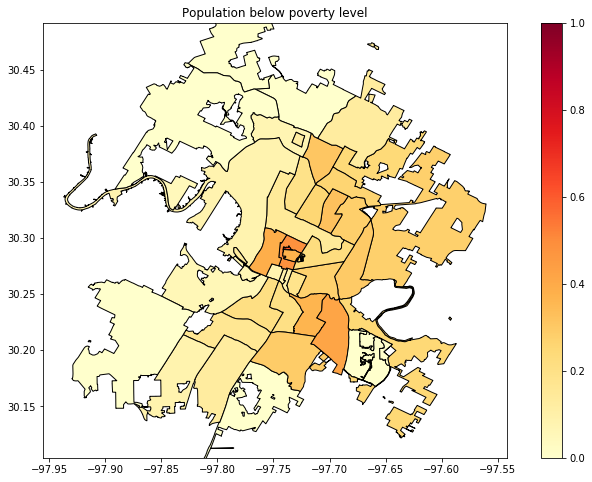

In [30]:
xlim = (-97.95558243542551, -97.54169755255776)
ylim = (30.10407831924847, 30.491603303384252)

temp = districts_from_census.copy()
temp['shade'] = temp['pov_HC02_EST_VC01'] / temp['pov_HC01_EST_VC01']
ax = temp.plot(column='shade', edgecolor='k', cmap='YlOrRd', vmin=0.0, vmax=1.0, legend=True, figsize=(12, 8))
plt.title('Population below poverty level')
ax.set_xlim(xlim)
ax.set_ylim(ylim);

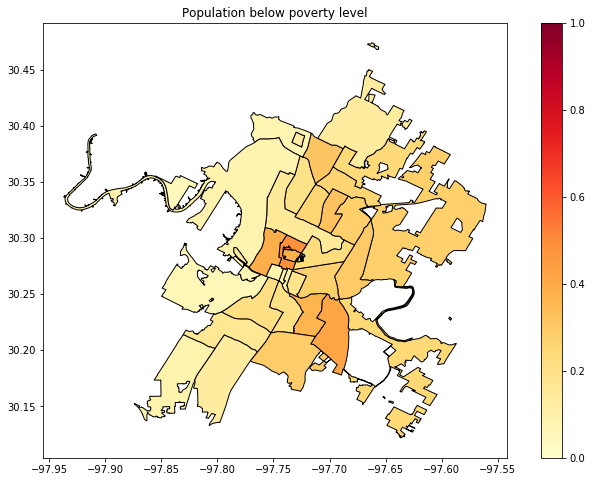

In [31]:
xlim = (-97.95558243542551, -97.54169755255776)
ylim = (30.10407831924847, 30.491603303384252)

temp = districts_from_census.copy()
temp['shade'] = temp['pov_HC02_EST_VC01'] / temp['pov_HC01_EST_VC01']
temp = temp[temp.shade.notnull()]
ax = temp.plot(column='shade', edgecolor='k', cmap='YlOrRd', vmin=0.0, vmax=1.0, legend=True, figsize=(12, 8))
plt.title('Population below poverty level')
ax.set_xlim(xlim)
ax.set_ylim(ylim);

## Summarize

### District information

In [32]:
districts_joined.shape

(53, 22)

In [33]:
districts_joined.head().drop('geometry', axis=1)

,NAME,SORTORDER,BATID,JURIID,COLOR,CODE,EXTERNALKE,BATTALIONC,DISTRICT,SECTOR,...,MODIFIED_D,INPUT_BY,MODIFIED_B,BUREAU,PATROL_ARE,AREACOMMAN,SHAPE_AREA,SHAPE_LEN,incident_count,crime_count
0,CHARLIE 4,1.0,400.0,11.0,16744576.0,1282,1282,CHAR,CHARLIE 4,CHARLIE,...,None,bmartinlimuel,None,CENTRAL,CENTRALEAST,512-974-5900,6.657440e+08,387953.791071,55,353
1,GEORGE 1,1.0,194.0,15.0,16744576.0,1298,1298,G1,GEORGE 1,GEORGE,...,None,bmartinlimuel,None,NORTH,DTAC,512-974-5203,2.790690e+07,23590.887752,40,85
2,GEORGE 2,1.0,194.0,15.0,16776960.0,1297,1297,G1,GEORGE 2,GEORGE,...,None,bmartinlimuel,None,NORTH,DTAC,512-974-5203,9.667245e+06,19773.819675,594,57
3,IDA 1,1.0,215.0,60.0,16744576.0,1307,1307,I1,IDA 1,IDA,...,None,bmartinlimuel,None,CENTRAL,NORTHCENTRAL,512-974-5203,1.054603e+08,48972.544807,105,440
4,IDA 2,1.0,215.0,60.0,16711680.0,1304,1304,I1,IDA 2,IDA,...,None,bmartinlimuel,None,CENTRAL,NORTHCENTRAL,512-974-5203,6.245594e+07,38742.443899,97,363


In [34]:
districts_joined.isnull().sum()

NAME               0
SORTORDER          0
BATID              0
JURIID             0
COLOR              0
CODE               0
EXTERNALKE         0
BATTALIONC         0
DISTRICT           0
SECTOR             0
INPUT_DATE         0
MODIFIED_D        50
INPUT_BY           0
MODIFIED_B        50
BUREAU             8
PATROL_ARE         0
AREACOMMAN         8
SHAPE_AREA         0
SHAPE_LEN          0
geometry           0
incident_count     0
crime_count        0
dtype: int64

### Census info reshaped into districts

In [35]:
districts_from_census.shape

(53, 400)

In [36]:
districts_from_census.head().drop('geometry', axis=1)

,ALAND,AWATER,dem_HC01_VC03,dem_HC02_VC03,dem_HC03_VC03,dem_HC01_VC04,dem_HC02_VC04,dem_HC01_VC05,dem_HC02_VC05,dem_HC01_VC08,...,pov_HC02_EST_VC77,pov_HC02_MOE_VC77,pov_HC01_EST_VC78,pov_HC01_MOE_VC78,pov_HC02_EST_VC78,pov_HC02_MOE_VC78,pov_HC01_EST_VC79,pov_HC01_MOE_VC79,pov_HC02_EST_VC79,pov_HC02_MOE_VC79
0,5.739556e+07,4.459999e+06,16844.338930,1634.657211,16844.338930,9002.911482,1062.937187,7841.427448,947.343037,1774.810485,...,61.445523,103.662643,374.808400,187.087571,166.507825,143.497605,321.928781,187.101272,235.059778,164.511769
1,2.410152e+06,1.826752e+05,4944.367506,509.844714,4944.367506,2577.940170,373.115218,2366.427336,336.622712,192.459498,...,15.967382,26.784625,385.530581,147.445448,111.195990,79.322207,287.966082,97.328903,183.973178,88.127982
2,8.178214e+05,8.036146e+04,1918.674393,215.384879,1918.674393,1193.002152,179.822717,725.672240,106.351559,42.272295,...,5.703386,9.058427,211.696791,90.247002,38.918295,32.878623,197.937888,58.710761,137.214050,47.975003
3,9.798541e+06,4.548481e+00,18335.447000,2039.271305,18335.447000,9190.659122,1290.623308,9144.787877,1406.030125,1756.805338,...,168.531480,174.830936,1072.632684,396.572708,468.939945,289.453796,1049.592469,499.510338,647.788404,388.141904
4,5.802940e+06,0.000000e+00,16364.280876,1786.831300,16364.280876,8763.612619,1238.202540,7600.668258,1154.747825,1362.100995,...,271.657936,267.336351,1058.190082,388.390523,387.081968,238.675476,1018.382097,337.949361,678.652042,303.124472


In [37]:
districts_from_census.isnull().sum(axis=1).value_counts()

# 5 entries with 397 nulls
# 48 entries without nulls

0      48
397     5
dtype: int64

# Making a model

## Prepare inputs and outputs

Just selecting some data...

In [38]:
districts_joined[['incident_count', 'crime_count']].head()

,incident_count,crime_count
0,55,353
1,40,85
2,594,57
3,105,440
4,97,363


In [39]:
dj = districts_joined
incident_count = dj['incident_count']
crime_count = dj['crime_count']

dfc = districts_from_census
total_pop = dfc['dem_HC01_VC03']
race_hispanic = dfc['dem_HC01_VC88']
race_white = dfc['dem_HC01_VC94']
race_black = dfc['dem_HC01_VC95']
below_poverty = dfc['pov_HC02_EST_VC01']
measured_poverty = dfc['pov_HC01_EST_VC01']

df = pd.DataFrame({
    'incident_ratio': incident_count / total_pop,
    'crime_ratio': crime_count / total_pop,
    'hispanic_pct': race_hispanic / total_pop,
    'white_pct': race_white / total_pop,
    'black_pct': race_black / total_pop,
    'poverty_pct': below_poverty / measured_poverty,    
})

# drop unpopulated areas, e.g. airport
# also implicitly dropping NaNs (came from missing tracts)
df = df[total_pop > 0]

df

,incident_ratio,crime_ratio,hispanic_pct,white_pct,black_pct,poverty_pct
0,0.003265,0.020957,0.602336,0.138870,0.229463,0.279839
1,0.008090,0.017191,0.536648,0.361530,0.059233,0.187197
2,0.309589,0.029708,0.107886,0.745062,0.035670,0.097290
3,0.005727,0.023997,0.451494,0.318124,0.195531,0.284367
4,0.005928,0.022182,0.609288,0.248187,0.106816,0.326033
5,0.005698,0.013001,0.452367,0.432973,0.069757,0.257123
6,0.003264,0.008830,0.256215,0.648907,0.023850,0.194879
7,0.003591,0.019173,0.654160,0.215372,0.078852,0.310259
8,0.002297,0.020389,0.589285,0.185554,0.132346,0.245448
9,0.215610,0.030307,0.107887,0.745061,0.035670,0.097290


## Create the model

Now we can finally create a model!

In [40]:
X = df.copy()
X = sm.add_constant(X)
X = X.drop('incident_ratio', axis=1)

y = df['incident_ratio'].copy()

model = sm.OLS(y, X)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         incident_ratio   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     14.79
Date:                Tue, 23 Oct 2018   Prob (F-statistic):           1.02e-07
Time:                        14:01:24   Log-Likelihood:                 80.595
No. Observations:                  40   AIC:                            -149.2
Df Residuals:                      34   BIC:                            -139.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1135      0.122      0.929      0.359      -0.135       0.362
crime_ratio      6.4268      0.802      8.011      0.000       4.796       8.057
hispanic_pct    -0.3565      0.128     -2.782      0.009      -0.617      -0.096
white_pct       -0.1035      0.141     -0.734      0.468      -0.390       0.183
black_pct       -0.1971      0.162     -1.220      0.231      -0.526       0.131
poverty_pct      0.0433      0.053      0.812      0.422      -0.065       0.152
==============================================================================
Omnibus:                       16.999   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.196
Skew:                           1.082   Prob(JB):                     4.57e-07
Kurtosis:                       6.583   Cond. No.                         173.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Ok, there is our model! The produced coefficients are not what we expected... What if we try logistic regression?

In [41]:
from scipy.special import logit

X = df.copy()
X = sm.add_constant(X)
X = X.drop('incident_ratio', axis=1)

y = df['incident_ratio'].copy()
y = logit(y)

model = sm.OLS(y, X)
results = model.fit()

results.summary()

# hehe

/home/andre/miniconda3/envs/cpe/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1523: RuntimeWarning: invalid value encountered in subtract
  model.endog - np.average(model.endog, weights=weights))**2)
/home/andre/miniconda3/envs/cpe/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/andre/miniconda3/envs/cpe/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/andre/miniconda3/envs/cpe/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         incident_ratio   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 23 Oct 2018   Prob (F-statistic):                nan
Time:                        14:01:24   Log-Likelihood:                    nan
No. Observations:                  40   AIC:                               nan
Df Residuals:                      34   BIC:                               nan
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const               nan        nan        nan        nan         nan         nan
crime_ratio         inf        nan        nan        nan         nan         nan
hispanic_pct        nan        nan        nan        nan         nan         nan
white_pct           nan        nan        nan        nan         nan         nan
black_pct           nan        nan        nan        nan         nan         nan
poverty_pct         nan        nan        nan        nan         nan         nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                     nan
Prob(Omnibus):                    nan   Jarque-Bera (JB):                  nan
Skew:                             nan   Prob(JB):                          nan
Kurtosis:                         nan   Cond. No.                         173.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
from scipy.special import logit

X = df.copy()
X = sm.add_constant(X)
X = X.drop('incident_ratio', axis=1)

y = df['incident_ratio'].copy()
y[y == 0] = 0.00014
y = logit(y)

model = sm.OLS(y, X)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         incident_ratio   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     19.54
Date:                Tue, 23 Oct 2018   Prob (F-statistic):           3.87e-09
Time:                        14:01:25   Log-Likelihood:                -54.650
No. Observations:                  40   AIC:                             121.3
Df Residuals:                      34   BIC:                             131.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -11.4121      3.591     -3.178      0.003     -18.709      -4.115
crime_ratio    199.2726     23.589      8.448      0.000     151.333     247.212
hispanic_pct     0.7649      3.769      0.203      0.840      -6.894       8.424
white_pct        5.0824      4.149      1.225      0.229      -3.350      13.515
black_pct       -1.6021      4.751     -0.337      0.738     -11.258       8.054
poverty_pct      1.1825      1.567      0.755      0.456      -2.002       4.367
==============================================================================
Omnibus:                        0.285   Durbin-Watson:                   1.736
Prob(Omnibus):                  0.867   Jarque-Bera (JB):                0.043
Skew:                           0.080   Prob(JB):                        0.979
Kurtosis:                       3.013   Cond. No.                         173.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Still weird coefficients hhmmm

In [43]:
X.corr()

# this is pretty revealing
# our regression probably doesn't know where to fix the coefficients because
# there's too little data and the values are correlated

# that's okay by now
# later we want to crank those values (yeah)

,const,crime_ratio,hispanic_pct,white_pct,black_pct,poverty_pct
const,NaN,NaN,NaN,NaN,NaN,NaN
crime_ratio,NaN,1.000000,0.664255,-0.582324,0.213610,0.060580
hispanic_pct,NaN,0.664255,1.000000,-0.933750,0.354900,0.373903
white_pct,NaN,-0.582324,-0.933750,1.000000,-0.612611,-0.463529
black_pct,NaN,0.213610,0.354900,-0.612611,1.000000,0.396738
poverty_pct,NaN,0.060580,0.373903,-0.463529,0.396738,1.000000


In [44]:
X = df.copy()
X = sm.add_constant(X)
X = X.drop('incident_ratio', axis=1)

y = df['incident_ratio'].copy()

huber_t = sm.RLM(y, X, M=sm.robust.norms.HuberT())
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         incident_ratio   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     19.54
Date:                Tue, 23 Oct 2018   Prob (F-statistic):           3.87e-09
Time:                        14:01:25   Log-Likelihood:                -54.650
No. Observations:                  40   AIC:                             121.3
Df Residuals:                      34   BIC:                             131.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -11.4121      3.591     -3.178      0.003     -18.709      -4.115
crime_ratio    199.2726     23.589      8.448      0.000     151.333     247.212
hispanic_pct     0.7649      3.769      0.203      0.840      -6.894       8.424
white_pct        5.0824      4.149      1.225      0.229      -3.350      13.515
black_pct       -1.6021      4.751     -0.337      0.738     -11.258       8.054
poverty_pct      1.1825      1.567      0.755      0.456      -2.002       4.367
==============================================================================
Omnibus:                        0.285   Durbin-Watson:                   1.736
Prob(Omnibus):                  0.867   Jarque-Bera (JB):                0.043
Skew:                           0.080   Prob(JB):                        0.979
Kurtosis:                       3.013   Cond. No.                         173.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Same thing with robust...